Author:
Arjun Chakrawal (arjun.chakrawal@pnnl.gov)
Created: Sat May 11 21:13:26 2024

In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import numpy as np
import pandas as pd
import sol_ivp_ as svp
import run_local_fitting as rlf
import time
%config InlineBackend.figure_format = 'svg'

In [6]:
# Option flags to control which analyses are run
# Setting True will remove existing files in the \tabels path used for creating figure in Figures.ipynb. New files will be created only after the simulation is completed.
local_fitting_flag = False  # Set to True to enable local fitting
local_fitting_post_processing_flag = False  # Set to True to enable post-processing of local fitting results

In [7]:
# Load fixed model parameters and plant decomposition data
fixed_param, plant_data = svp.load_fix_par_and_data()
# Combine Study and Species columns to get unique study-species combinations
temp = plant_data['Study'] + plant_data['Species']
len(temp.unique())

89

### Test model simulation for a selected study and species

Execution time: 0.190861 seconds


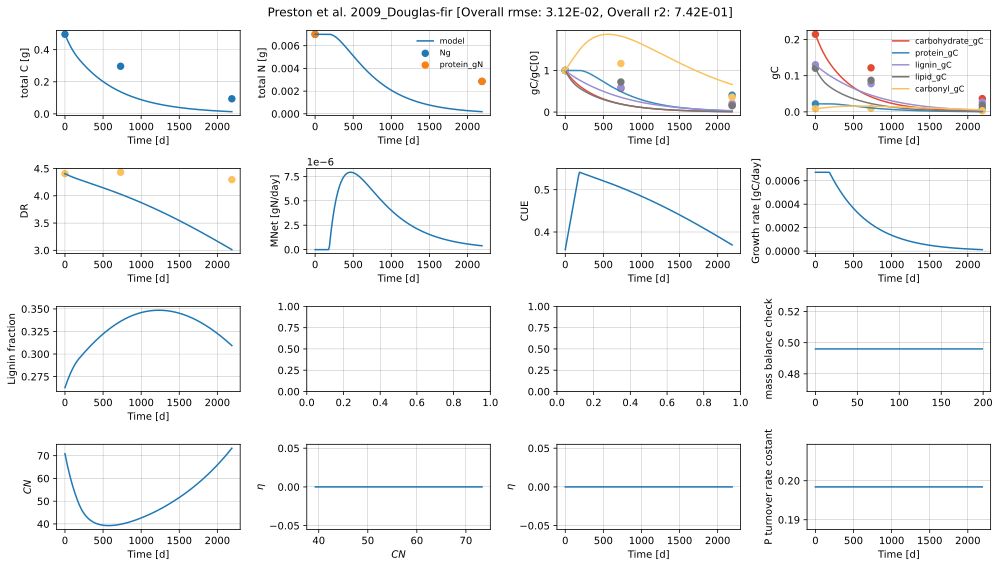

In [10]:
T = 273  # Temperature in Kelvin
studyname = 'Preston et al. 2009'
# studyname = 'Mathers et al., 2007'

# Subset data for the selected study
subset_df = plant_data[plant_data['Study'] == studyname].reset_index(drop=True)
SP = subset_df['Species'].unique()
data = subset_df[subset_df['Species'] == SP[0]].reset_index(drop=True)

# Determine which columns to use based on available nitrogen data
if len(data['totNg'].dropna()) == len(data['protein_gC'].dropna()):
    data_col = ['carbohydrate_gC', 'protein_gC', 'lignin_gC', 'lipid_gC', 'carbonyl_gC']
else:
    data_col = ["totNg", 'carbohydrate_gC', 'protein_gC', 'lignin_gC', 'lipid_gC', 'carbonyl_gC', 'DR']

# Initial fractions of carbon pools
init_fracC = data[['carbohydrate_gC', 'protein_gC', 'lignin_gC', 'lipid_gC', 'carbonyl_gC']].iloc[0].values
finalT = data['time day'].iloc[-1]  # Final simulation time

# Calculate initial C:N ratio
CN0 = np.sum(init_fracC) / (init_fracC[1] / 3.2)

data.columns
# plt.close('all')
L = np.linspace(0, 1, 50)

# Initial guess for model parameters (median values from previous estimations)
guess_param = {'vh_max': 0.0035, 'vp_max': 0.006, 'vlig': 0.002,
               'vlip': 0.006, 'vCr': 0.001}

# Estimate maximum inorganic N input based on data gradients
dt = data['time day'][1] - data['time day'][0]
if (np.sum(~np.isnan(data['totNg'])) > np.sum(~np.isnan(data['protein_gN']))):
    Imax = np.nanmax(np.gradient(data['totNg'], dt))
else:
    Imax = np.nanmax(np.gradient(data['protein_gN'], dt))

# Set inorganic N input in fixed parameters
if Imax > 0:
    fixed_param['Inorg'] = Imax
else:
    fixed_param['Inorg'] = 1e-8

# Time vector for simulation
tsim = np.linspace(0, finalT, 200)

# Set model feature flags
protection, CUEflag, voflag = True, True, True
protection, CUEflag, voflag = False, False, False

# Select adaptation strategy
adapt_flag = 'N-Retention'
adapt_flag = 'Flexible CUE'

# Convert guess_param to array for model input
guess_param_val = np.array(list(guess_param.values()))

# Run model simulation and measure execution time
start_time = time.time()
df = svp.litter_decay_model(tsim, init_fracC, guess_param_val, fixed_param, adapt_flag, protection, CUEflag, voflag)
end_time = time.time()
print(f"Execution time: {end_time - start_time:.6f} seconds")

# Plot model results and compare to data
fig, df = svp.plot_model(tsim, fixed_param, guess_param_val, init_fracC, data_col=data_col, data=data, adapt_flag=adapt_flag,
                         protection=protection, CUEflag=CUEflag, voflag=voflag)


### Test parameter fitting to data

fitting in progress...
fitting completed...
Execution time: 7.873390 seconds
{'vh_max': 0.0013973821548406633, 'vp_max': 0.00324002762452065, 'vlig': 0.0010786107758840489, 'vlip': 0.0019489594122333311, 'vCr': 0.001706808911953803}


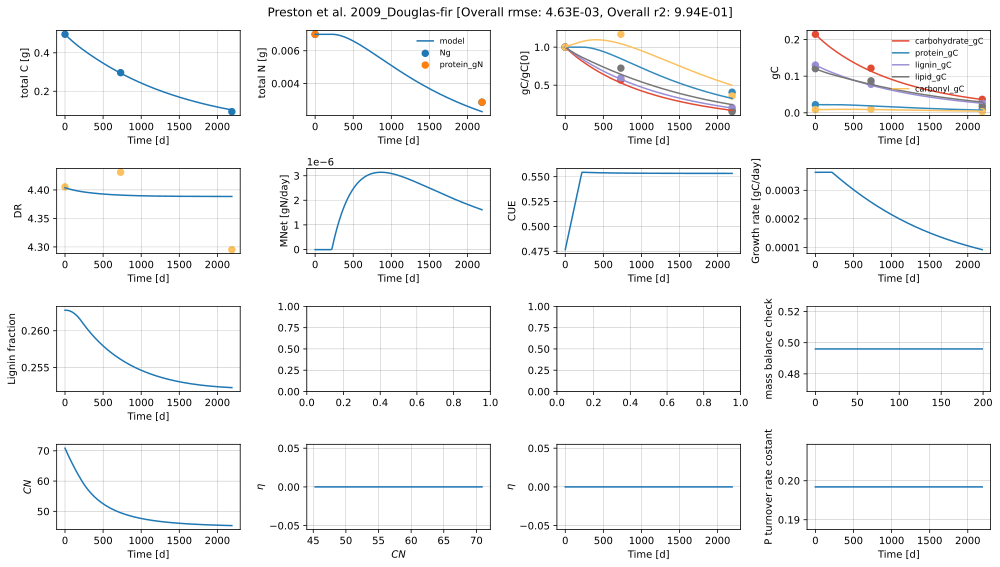

In [12]:
start_time = time.time()
tsim = np.linspace(0, finalT, 25)
guess_param = {'vh_max': 0.0035, 'vp_max': 0.006, 'vlig': 0.0045,
               'vlip': 0.006, 'vCr': 0.002}  # Updated guess for fitting

# Fit model parameters to data using least-squares optimization
est_pars, est_pars_se = svp.fit_data(
    guess_param, init_fracC, fixed_param, tsim, T, data, data_col, adapt_flag,
    protection, CUEflag, voflag, loss='soft_l1'
)
end_time = time.time()
print(f"Execution time: {end_time - start_time:.6f} seconds")

print(est_pars)

# Simulate and plot model with fitted parameters
tsim = np.linspace(0, finalT, 200)
fig, df = svp.plot_model(tsim, fixed_param, list(est_pars.values()), init_fracC, data_col=data_col, data=data, adapt_flag=adapt_flag,
                         protection=protection, CUEflag=CUEflag, voflag=voflag)


## Local fitting
### running full simulation with all fitting would take several hours to complete.

In [13]:

# Loop over both adaptation strategies: 'N-Retention' and 'Flexible CUE'
for adapt_flag in ['N-Retention', 'Flexible CUE']:
    # Run local fitting if the flag is set
    if local_fitting_flag:
        start_time = time.time()
        # Run fitting for each combination of protection, CUEflag, and voflag
        rlf.run_fitting(adapt_flag=adapt_flag, protection=False, CUEflag=False, voflag=False)
        rlf.run_fitting(adapt_flag=adapt_flag, protection=False, CUEflag=True, voflag=False)
        rlf.run_fitting(adapt_flag=adapt_flag, protection=True, CUEflag=True, voflag=False)
        rlf.run_fitting(adapt_flag=adapt_flag, protection=True, CUEflag=True, voflag=True)
        end_time = time.time()
        print(f"Execution time: {end_time - start_time:.6f} seconds")
    # Run post-processing if the flag is set
    if local_fitting_post_processing_flag:
        # Post-process results for each parameter combination
        df_estpar = pd.read_excel('tables/' + adapt_flag + '/Local_estpar_protection_False_vo_False_CUE_False.xlsx')
        rlf.run_post_process(df_estpar, adapt_flag=adapt_flag, protection=False, CUEflag=False, voflag=False)

        df_estpar = pd.read_excel('tables/' + adapt_flag + '/Local_estpar_protection_False_vo_False_CUE_True.xlsx')
        rlf.run_post_process(df_estpar, adapt_flag=adapt_flag, protection=False, CUEflag=True, voflag=False)

        df_estpar = pd.read_excel('tables/' + adapt_flag + '/Local_estpar_protection_True_vo_False_CUE_True.xlsx')
        rlf.run_post_process(df_estpar, adapt_flag=adapt_flag, protection=True, CUEflag=True, voflag=False)

        df_estpar = pd.read_excel('tables/' + adapt_flag + '/Local_estpar_protection_True_vo_True_CUE_True.xlsx')
        rlf.run_post_process(df_estpar, adapt_flag=adapt_flag, protection=True, CUEflag=True, voflag=True)